# **WARNING**

In order for this notebook to run, you must first run the notebook `2_0_generate_turn_data.ipynb` and generate the file `result/singlegame_results/player10_turn_results.csv` which contains the optimal policy and value functions for the solved MDPs for different player skill model and epsilon combinatinos. It is also important to make sure that all combinations you want to analyse in this file were generated during this process. 

# 1.0 Notebook Parameters

Please specify the following variables:
1. `project_directory`: your project directory path
2. `epsilon_list`: the list of execution error multiplers (epsilon) that you want to consider in your analysis.
3. `player_id`: the players (i.e. skill model) you want to consider in your analysis; use one base model and scale it with different epsilons; this should match whatever was used in `1_0_generate_noturn_data.ipynb`.

In [ ]:
# Change this to the project directory path for your computer  
project_directory = '/Users/rachael/Desktop/darts-thesis'

# Set the epsilons that will be considered in this analysis 
epsilon_list = [1,2,3,4,5,6,7,8,9]

# Set the ID of the player skill models you want to use 
    # 10 - symmetric DB skill model that we were using up until now 
    # ? - "average pro" skill model generated by H & W 
player_id = 10 


# 2.0 Notebook Setup

Import libraries and run prerequisites.

In [ ]:
# Import and configure modules from this project

import os

os.chdir(project_directory)

import function_init_simple_mdp as imdp
import function_helpers_singleplayer as h

import class_handicap as hc 
handicap = hc.Handicap(results_file_name='./result/singlegame_results/player10_noturn_results.csv', epsilon_list = epsilon_list)


In [1]:
# Import and configure external modules

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm, colors
import seaborn as sns

# sns.set_theme() # uncomment if you want the seaborn visual theme

def color_map_color(value, cmap_name='Wistia', vmin=0, vmax=1):
    # norm = plt.Normalize(vmin, vmax)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = colors.rgb2hex(rgb)
    return color


In [ ]:
# Load data
df = pd.read_csv('result/singlegame_results/player10_turn_results.csv')

# Read only the relevant columns - note that this will result in duplicates if you include multiple players 
df = df[['epsilon','tokens','score','remaining_throws','score_gained','optimal_value','optimal_policy']]

# Map to policy action names 
a_map = {i:imdp.a_list[i] for i in range(len(imdp.a_list))}
df['optimal_policy_name'] = df['optimal_policy'].map(a_map)

In [3]:
df = pd.read_csv('player10_results.csv')
df = df[['epsilon','tokens','score','remaining_throws','score_gained','optimal_value','optimal_policy']]

# Map to policy action names 
a_map = {i:imdp.a_list[i] for i in range(len(imdp.a_list))}
df['optimal_policy_name'] = df['optimal_policy'].map(a_map)

In [4]:
epsilon_list = list(df.epsilon.unique())
epsilon_list = list(range(1,10))
# epsilon_list = [1,2,4,8,16,32,64,128]
# epsilon_list = [1,2,4,6,8,10,12,14,16,18,20]

## Existing Spot Point

In [5]:
expected_turns_list = []
for epsilon in epsilon_list: 
    t = df.loc[(df.score==501) & (df.epsilon==epsilon) & (df.tokens==0) & (df.remaining_throws==3)].optimal_value.values[0]
    expected_turns_list.append(t)

ppd_list = [501 / (expected_turns_list[i]*3) for i in range(len(expected_turns_list))]


In [6]:
ppd_list

[29.759872335145815,
 22.483000180564385,
 18.62329519838024,
 16.329362870083507,
 14.7351237035544,
 13.54604571290418,
 12.619835354226646,
 11.871971270753892,
 11.249253807470208]

In [7]:
ssl_list = []

for i in range(len(ppd_list)):

    for j in range(i,len(ppd_list)):

        hppd = ppd_list[i]
        lppd = ppd_list[j]

        ssl = round(501*(lppd/hppd))

        ssl_list.append([epsilon_list[i],epsilon_list[j],ssl])

#ssl_list

ssl_list_full = []

for ssl in ssl_list: 

    th1 = df.loc[(df.score==501) & (df.epsilon==ssl[0]) & (df.tokens==0)].optimal_value.values[0] #* 3
    th2 = df.loc[(df.score==ssl[2]) & (df.epsilon==ssl[1]) & (df.tokens==0)].optimal_value.values[0] #* 3

    ssl_list_full.append([ssl[0],ssl[1],ssl[2],th1,th2, th2-th1])

In [9]:
spot_point_df = pd.DataFrame(ssl_list_full,columns=['p1_epsilon','p2_epsilon','p2_starting_score','p1_expected_turns','p2_expected_turns','diff_expected_turns'])
spot_point_df.head()

,p1_epsilon,p2_epsilon,p2_starting_score,p1_expected_turns,p2_expected_turns,diff_expected_turns
0,1,1,501,6.276728,6.276728,0.000000
1,1,2,378,6.276728,6.606120,0.329392
2,1,3,314,6.276728,6.924509,0.647781
3,1,4,275,6.276728,7.238911,0.962183
4,1,5,248,6.276728,7.568076,1.291348


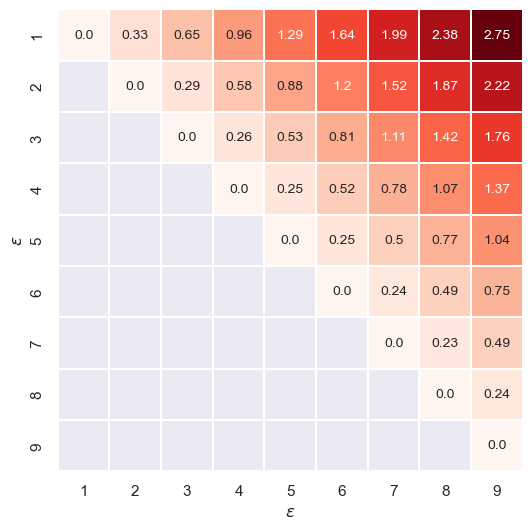

In [33]:
result = spot_point_df.pivot(index='p1_epsilon',columns='p2_epsilon',values='diff_expected_turns')
result = result.round(2)
#print(result)
#sns.heatmap(result,annot=labels,fmt="",cmap='RdYlGn',linewidths=0.30,ax=ax)
fig = sns.set(rc={'figure.figsize':(6,6)})
fig = sns.heatmap(result,annot=True,annot_kws={"size": 10},fmt="",cmap='Reds',linewidths=0.30,cbar=False)
#fig = plt.title("Additional expected turns required for the weaker player \nusing heuristic spot point handicap system")
fig = plt.xlabel(r'$\epsilon$')
fig = plt.ylabel(r'$\epsilon$')

In [12]:
df0 = df.loc[df.tokens==0].copy()
df0 = df0.loc[df0.remaining_throws==3].copy()
df0['ppd'] = df0.score / (df0.optimal_value * 3) 

# Create dataframes for values at 501 for each token value 
epsilon_dfs = []

for e in range(len(epsilon_list)):
    epsilon = epsilon_list[e]
    temp = df0.loc[df0.epsilon==epsilon].set_index('score')['optimal_value'].copy()
    epsilon_dfs.append(temp)


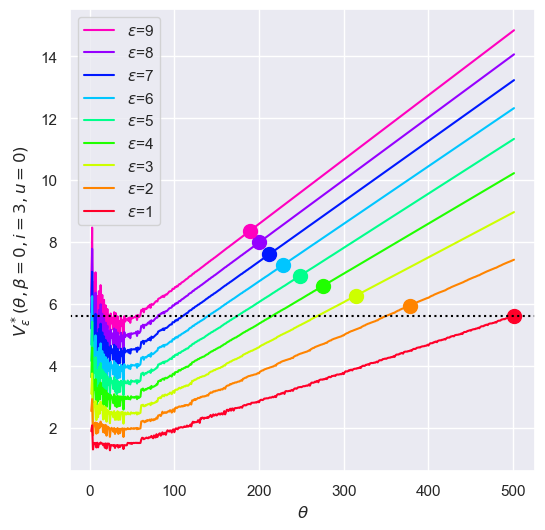

In [34]:
e_leg = []
vmax=max(epsilon_list)
vmin=min(epsilon_list)


# Plot each token line 
for e in reversed(range(len(epsilon_list))):
    epsilon = epsilon_list[e]
    e_leg.append(r'$\epsilon$={}'.format(epsilon))
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    fig = plt.plot(epsilon_dfs[e],color=color)

fig = plt.legend(e_leg) 

for e in range(len(epsilon_list)):
    epsilon = epsilon_list[e]
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    s = spot_point_df.loc[(spot_point_df.p1_epsilon==1) & (spot_point_df.p2_epsilon==epsilon)]['p2_starting_score'].values[0]
    fig = plt.plot(s, epsilon_dfs[e][s], marker="o", markersize=10, color=color)


#fig = plt.title('Change in expected remaining throws as the game progresses for players of different skill levels')
# fig = plt.xlabel('Score')
fig = plt.xlabel(r'$\theta$')
fig = plt.axhline(epsilon_dfs[0][501],color='black',linestyle='dotted') 
# fig = plt.ylabel(r'$V^{*}(Score,\beta=0)$')
fig = plt.ylabel(r'$V^*_{\epsilon}(\theta,\beta=0,i=3,u=0)$')
fig = plt.legend(e_leg)

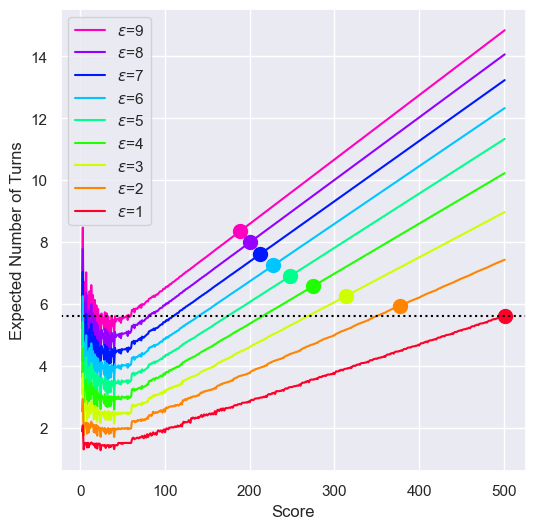

In [37]:
e_leg = []
vmax=max(epsilon_list)
vmin=min(epsilon_list)

fig = sns.set(rc={'figure.figsize':(6,6)})

# Plot each token line 
for e in reversed(range(len(epsilon_list))):
    epsilon = epsilon_list[e]
    e_leg.append(r'$\epsilon$={}'.format(epsilon))
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    fig = plt.plot(epsilon_dfs[e],color=color)

fig = plt.legend(e_leg) 

for e in range(len(epsilon_list)):
    epsilon = epsilon_list[e]
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    s = spot_point_df.loc[(spot_point_df.p1_epsilon==1) & (spot_point_df.p2_epsilon==epsilon)]['p2_starting_score'].values[0]
    fig = plt.plot(s, epsilon_dfs[e][s], marker="o", markersize=10, color=color)


#fig = plt.title('Change in expected remaining throws as the game progresses for players of different skill levels')
# fig = plt.xlabel('Score')
fig = plt.xlabel(r'Score')
fig = plt.axhline(epsilon_dfs[0][501],color='black',linestyle='dotted') 
fig = plt.ylabel(r'Expected Number of Turns')
fig = plt.legend(e_leg)

## Optimized Dynamic Credits

In [26]:
import helpers as h
import function_board as fb
import init_simple_mdp as imdp

name_pa = 'player{}'.format(10)
data_parameter_dir = fb.data_parameter_dir

epsilon_list = list(range(1,10))

bullseye_probs = []
for epsilon in epsilon_list: 
    [aiming_grid, prob_grid_normalscore_nt, prob_grid_singlescore_nt, prob_grid_doublescore_nt, prob_grid_triplescore_nt, prob_grid_bullscore_nt] = h.load_aiming_grid(name_pa, epsilon=epsilon, data_parameter_dir=data_parameter_dir, grid_version='custom_no_tokens')
    bullseye_probs.append(prob_grid_bullscore_nt[728].copy())

load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/player10_e1_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/player10_e2_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/player10_e3_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/player10_e4_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/player10_e5_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/player10_e6_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/player10_e7_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/player10_e8_gaussin_prob_grid_custom_no_tok

In [27]:
prob_list = []

for i in range(len(epsilon_list)):
    db_prob = bullseye_probs[i][1]
    sb_prob = bullseye_probs[i][0]
    other = 1 - db_prob - sb_prob
    epsilon = epsilon_list[i]
    prob_list.append([epsilon,db_prob,sb_prob,other])


In [45]:
df_skill = pd.DataFrame(prob_list,columns= ['epsilon','DB','SB','Other'])
df_skill = df_skill.set_index('epsilon')
# fig = df_skill.plot(colormap='winter')
# fig = plt.xlabel('$\epsilon$')
# fig = plt.ylabel('Probability of Hitting Region')
# fig = plt.title('Probability of Hitting Different Regions around DB as $\epsilon$ increases.')

In [30]:
df_skill_n = df_skill * 30
df_skill_n_round = df_skill_n.round()

print(df_skill_n_round.sum(axis=1))
df_skill_n_round

epsilon
1    30.0
2    30.0
3    30.0
4    30.0
5    30.0
6    30.0
7    30.0
8    29.0
9    30.0
dtype: float64


,DB,SB,Other
epsilon,,,
1,10.0,16.0,4.0
2,5.0,14.0,11.0
3,4.0,11.0,15.0
4,3.0,9.0,18.0
5,2.0,8.0,20.0
6,2.0,7.0,21.0
7,2.0,6.0,22.0
8,1.0,5.0,23.0
9,1.0,5.0,24.0


In [15]:
df = pd.read_csv('player10_results.csv')
df = df[['epsilon','tokens','score','remaining_throws','score_gained','optimal_value','optimal_policy']]

# Map to policy action names 
a_map = {i:imdp.a_list[i] for i in range(len(imdp.a_list))}
df['optimal_policy_name'] = df['optimal_policy'].map(a_map)

epsilon_list = [1,2,3,4,5,6,7,8,9]

# Get dataframe only for score values at 501 
df_501 = df.loc[df.score==501]
df_501 = df_501.loc[df_501.remaining_throws==3]
#df_501 = df_501.loc[df_501.epsilon <= 10]

# Create dataframes for values at 501 for each token value 
epsilon_dfs = []

for e in range(len(epsilon_list)):
    epsilon = epsilon_list[e]
    temp = df_501.loc[df_501.epsilon==epsilon].set_index('tokens')['optimal_value'].copy()
    epsilon_dfs.append(temp)

In [16]:
def linear_interpolation(x1,x2,y1,y2,y):
    x = x1 - ((y1-y)/(y1-y2))*(x1-x2)
    return x 

In [17]:
handicap_vals = {}

for i in range(len(epsilon_list)):

    handicap_vals[epsilon_list[i]] = {}

for i in range(len(epsilon_list)):

    stronger_no_token = epsilon_dfs[i][0]

    for j in range(len(epsilon_list)):

        if epsilon_list[i] <= epsilon_list[j]: 

            df_j = epsilon_dfs[j]

            for b in range(1,len(df_j)):

                x1 = b-1
                x2 = b 
                y1 = df_j[b-1]
                y2 = df_j[b]

                if (stronger_no_token <= y1) & (stronger_no_token >= y2):

                    handicap = linear_interpolation(x1,x2,y1,y2,stronger_no_token)

                    handicap_vals[epsilon_list[i]][epsilon_list[j]] = handicap


In [18]:
handicap_list = []

for i in range(len(epsilon_list)):

    handicap_sub_list = []

    for j in range(len(epsilon_list)):

        try: 
            handicap = handicap_vals[epsilon_list[i]][epsilon_list[j]]
            handicap_sub_list.append(handicap)
        except: 
            handicap_sub_list.append(1000)
    
    handicap_list.append(handicap_sub_list)

In [19]:
df_handicap = pd.DataFrame(handicap_list)
df_handicap.index = epsilon_list
df_handicap.columns = epsilon_list
df_handicap = df_handicap.replace(1000,np.nan)
df_handicap = df_handicap.round(2)

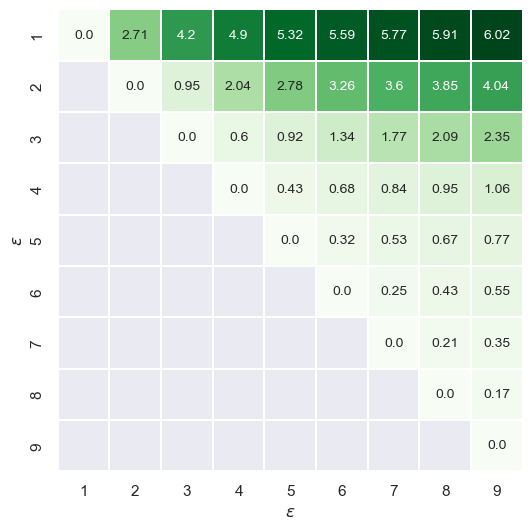

In [20]:
fig = sns.set(rc={'figure.figsize':(6,6)})
fig = sns.heatmap(df_handicap,annot=True,annot_kws={"size": 10},fmt="",cmap='Greens',linewidths=0.30,cbar=False)
#fig = plt.title("Difference in expected throws using spot point handicap system")
fig = plt.xlabel(r'$\epsilon$')
fig = plt.ylabel(r'$\epsilon$')

## Optimized Spot Point

In [21]:
df0 = df.loc[df.tokens==0].copy()
df0 = df0.loc[df0.remaining_throws==3].copy()

# Create dataframes for values at 501 for each token value 
epsilon_dfs = []

for e in range(len(epsilon_list)):
    epsilon = epsilon_list[e]
    temp = df0.loc[df0.epsilon==epsilon].set_index('score')['optimal_value'].copy()
    epsilon_dfs.append(temp)


In [22]:
epsilon_dfs[i][501]
epsilon_dfs[j]
df


,epsilon,tokens,score,remaining_throws,score_gained,optimal_value,optimal_policy,optimal_policy_name
0,1,0,2,1,0,2.232611,55,D1-cc-m
1,1,1,2,1,0,1.000000,752,D1
2,1,2,2,1,0,1.000000,752,D1
3,1,3,2,1,0,1.000000,752,D1
4,1,4,2,1,0,1.000000,752,D1
...,...,...,...,...,...,...,...,...
14947585,100,5,501,3,0,8.779259,728,DB-c
14947586,100,6,501,3,0,7.310111,728,DB-c
14947587,100,7,501,3,0,5.840758,728,DB-c
14947588,100,8,501,3,0,4.370963,728,DB-c


In [23]:
handicap_vals = {}

for i in range(len(epsilon_list)):

    handicap_vals[epsilon_list[i]] = {}

for i in range(len(epsilon_list)):

    stronger_no_token = epsilon_dfs[i][501] 

    for j in range(len(epsilon_list)):

        #if j <= i:
        if epsilon_list[i] <= epsilon_list[j]: 

            df_j = epsilon_dfs[j] 

            for s in range(3,502):

                x1 = s-1
                x2 = s 
                y1 = df_j[s-1] 
                y2 = df_j[s] 

                # print(f"\t {i}-{j}-{s}")
                # print(stronger_no_token,y1,y2)

                if (stronger_no_token >= y1) & (stronger_no_token <= y2):

                    handicap = linear_interpolation(x1,x2,y1,y2,stronger_no_token)

                    handicap_vals[epsilon_list[i]][epsilon_list[j]] = handicap
                



In [24]:
handicap_list = []

for i in range(len(epsilon_list)):

    handicap_sub_list = []

    for j in range(len(epsilon_list)):

        try: 
            handicap = handicap_vals[epsilon_list[i]][epsilon_list[j]]
            handicap_sub_list.append(handicap)
        except: 
            handicap_sub_list.append(1000)
    
    handicap_list.append(handicap_sub_list)

In [25]:
df_handicap = pd.DataFrame(handicap_list)
df_handicap.index = epsilon_list
df_handicap.columns = epsilon_list
df_handicap = df_handicap.replace(1000,np.nan)
df_handicap = df_handicap.round(2)
df_handicap

,1,2,3,4,5,6,7,8,9
1,501.0,350.21,269.06,215.54,174.44,139.75,110.28,80.71,59.42
2,NaN,501.00,394.74,327.91,278.13,237.66,203.05,172.40,144.10
3,NaN,NaN,501.00,423.10,365.94,320.37,282.10,248.58,218.31
4,NaN,NaN,NaN,501.00,437.83,388.06,346.73,310.95,278.89
5,NaN,NaN,NaN,NaN,501.00,447.53,403.51,365.71,332.10
6,NaN,NaN,NaN,NaN,NaN,501.00,454.57,414.95,379.95
7,NaN,NaN,NaN,NaN,NaN,NaN,501.00,459.74,423.46
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,501.00,463.55
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,501.00


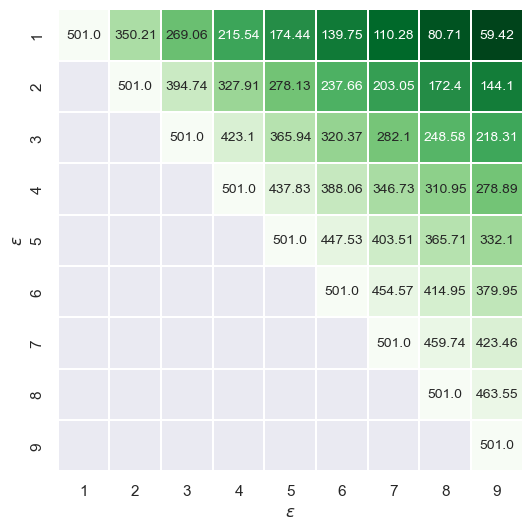

In [26]:
fig = sns.set(rc={'figure.figsize':(6,6)})
fig = sns.heatmap(df_handicap,annot=True,annot_kws={"size": 10},fmt="",cmap='Greens_r',linewidths=0.30,cbar=False)
#fig = plt.title("Difference in expected throws using spot point handicap system")
fig = plt.xlabel(r'$\epsilon$')
fig = plt.ylabel(r'$\epsilon$')

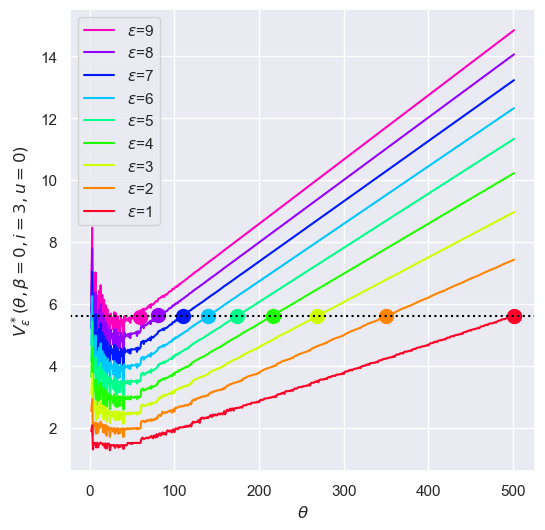

In [36]:
e_leg = []
vmax=max(epsilon_list)
vmin=min(epsilon_list)

# Plot each token line 
for e in reversed(range(len(epsilon_list))):
    epsilon = epsilon_list[e]
    e_leg.append(r'$\epsilon$={}'.format(epsilon))
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    fig = plt.plot(epsilon_dfs[e],color=color)

fig = plt.legend(e_leg) 

for e in range(len(epsilon_list)):
    epsilon = epsilon_list[e]
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    s = int(round(handicap_vals[1][epsilon]))
    fig = plt.plot(s, epsilon_dfs[e][s], marker="o", markersize=10, color=color)


#fig = plt.title('Change in expected remaining throws as the game progresses for players of different skill levels')
# fig = plt.xlabel('Score')
fig = plt.xlabel(r'$\theta$')
fig = plt.axhline(epsilon_dfs[0][501],color='black',linestyle='dotted') 
# fig = plt.ylabel(r'$V^{*}(Score,\beta=0)$')
fig = plt.ylabel(r'$V^*_{\epsilon}(\theta,\beta=0,i=3,u=0)$')
fig = plt.legend(e_leg)

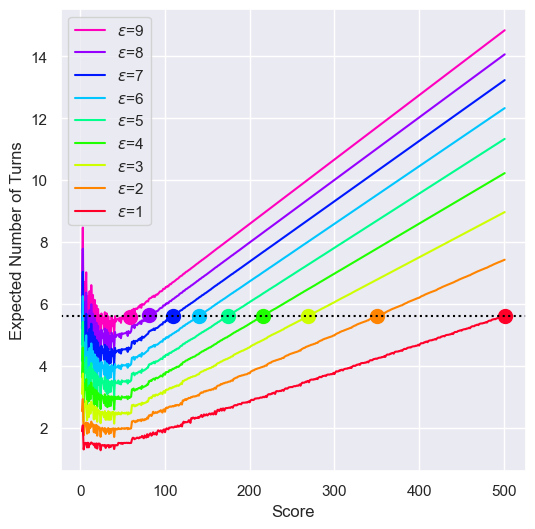

In [38]:
e_leg = []
vmax=max(epsilon_list)
vmin=min(epsilon_list)

# Plot each token line 
for e in reversed(range(len(epsilon_list))):
    epsilon = epsilon_list[e]
    e_leg.append(r'$\epsilon$={}'.format(epsilon))
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    fig = plt.plot(epsilon_dfs[e],color=color)

fig = plt.legend(e_leg) 

for e in range(len(epsilon_list)):
    epsilon = epsilon_list[e]
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    s = int(round(handicap_vals[1][epsilon]))
    fig = plt.plot(s, epsilon_dfs[e][s], marker="o", markersize=10, color=color)


#fig = plt.title('Change in expected remaining throws as the game progresses for players of different skill levels')
# fig = plt.xlabel('Score')
fig = plt.xlabel(r'Score')
fig = plt.axhline(epsilon_dfs[0][501],color='black',linestyle='dotted') 
# fig = plt.ylabel(r'$V^{*}(Score,\beta=0)$')
fig = plt.ylabel(r'Expected Number of Turns')
fig = plt.legend(e_leg)

## Spot Dart 

In [27]:
epsilon_list = [1,2,3,4,5,6,7,8,9]#,25,50,100]

df_501_b0 = df.loc[(df.score==501) & (df.tokens==0) & (df.remaining_throws==3)]

In [28]:
handicap_list = []

for i in range(len(epsilon_list)):

    handicap_sub_list = []

    v501_i = df_501_b0[df_501_b0.epsilon==epsilon_list[i]].optimal_value.values[0] 

    for j in range(len(epsilon_list)):

        v501_j = df_501_b0[df_501_b0.epsilon==epsilon_list[j]].optimal_value.values[0] 

        handicap = v501_j - v501_i

        if handicap >= 0: 
            handicap_sub_list.append(handicap)
        else: 
            handicap_sub_list.append(1000)
    
    handicap_list.append(handicap_sub_list)

In [29]:
df_handicap = pd.DataFrame(handicap_list)
df_handicap.index = epsilon_list
df_handicap.columns = epsilon_list
df_handicap = df_handicap.replace(1000,np.nan)
df_handicap = df_handicap.round(2)
df_handicap

,1,2,3,4,5,6,7,8,9
1,0.0,1.82,3.36,4.62,5.72,6.72,7.62,8.46,9.23
2,NaN,0.00,1.54,2.80,3.91,4.90,5.81,6.64,7.42
3,NaN,NaN,0.00,1.26,2.37,3.36,4.27,5.10,5.88
4,NaN,NaN,NaN,0.00,1.11,2.10,3.01,3.84,4.62
5,NaN,NaN,NaN,NaN,0.00,0.99,1.90,2.73,3.51
6,NaN,NaN,NaN,NaN,NaN,0.00,0.90,1.74,2.52
7,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.83,1.61
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.78
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00


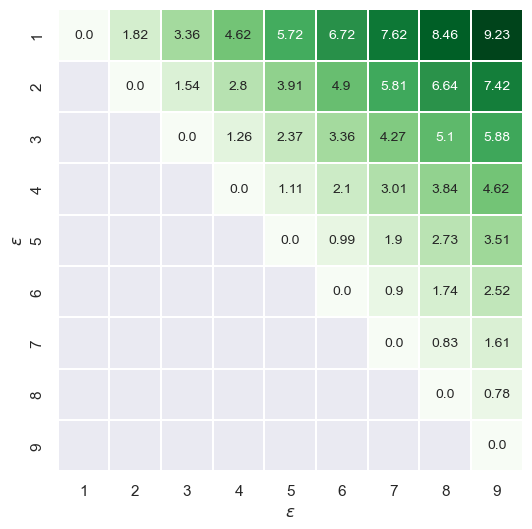

In [30]:
fig = sns.set(rc={'figure.figsize':(6,6)})
fig = sns.heatmap(df_handicap,annot=True,annot_kws={"size": 10},fmt="",cmap='Greens',linewidths=0.30,cbar=False)
#fig = plt.title("Difference in expected throws using spot point handicap system")
fig = plt.xlabel(r'$\epsilon$')
fig = plt.ylabel(r'$\epsilon$')